In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math
from scipy.cluster.hierarchy import fcluster, linkage
from collections import defaultdict
from tqdm import tqdm
d1 = '/data2/hang/SIA/SIA_luggage_damages/MissingWheel/ebay_luggages_pos_wheel_context_box.json'
d2 = '/data2/hang/SIA/SIA_luggage_damages/MissingWheel/wheel-luggage_parts_annotations_total_2609_newbody_pos_wheel_context_box.json'

data1 = [json.loads(l) for l in open(d1).readlines()]
data2 = [json.loads(l) for l in open(d2).readlines()]

print(len(data1))
print(len(data2))

9791
3874


In [3]:
data1[0]

{'id': 1,
 'img_path': '/data2/thang/crawl/SIA_scratch/ebay_crawl_used_luggage_images/images/Plastic/Plastic--155450733300--https_~~i.ebayimg.com~images~g~zEkAAOSwlmNkDgOe~s-l1600.webp',
 'pos_wheel_context_box': [[0, 603, 857, 1200]],
 'reliable_wheel_box': [[127, 1177, 284, 1200]],
 'all_wheel_box': [[127, 1177, 284, 1200]],
 'body_box': [45, 48, 1571, 1246],
 'body_mask': [[729, 63],
  [728, 64],
  [701, 64],
  [700, 65],
  [694, 65],
  [693, 64],
  [692, 64],
  [691, 65],
  [616, 65],
  [615, 66],
  [609, 66],
  [608, 67],
  [574, 67],
  [573, 68],
  [542, 68],
  [541, 69],
  [527, 69],
  [526, 70],
  [505, 70],
  [504, 71],
  [480, 71],
  [479, 72],
  [460, 72],
  [459, 73],
  [435, 73],
  [434, 74],
  [418, 74],
  [417, 75],
  [406, 75],
  [405, 76],
  [390, 76],
  [389, 77],
  [374, 77],
  [373, 78],
  [359, 78],
  [358, 79],
  [349, 79],
  [348, 80],
  [338, 80],
  [337, 81],
  [330, 81],
  [329, 82],
  [317, 82],
  [316, 83],
  [304, 83],
  [303, 84],
  [292, 84],
  [291, 85],

In [4]:
data2[0]

{'id': 0,
 'img_path': '/data2/hang/datasets/coco/sia/luggage_parts/total_images/L2tmL0hUQjE3VGdzalE3bUJLTmpTWkZ5cTZ6eWRGWGFGLzIyNDc4MTY3MS9IVEIxN1Rnc2pRN21CS05qU1pGeXE2enlkRlhhRi5qcGc.jpg',
 'pos_wheel_context_box': [[238, 487, 477, 689],
  [172, 590, 411, 796],
  [239, 0, 478, 225],
  [176, 189, 415, 404]],
 'reliable_wheel_box': [[280, 570, 395, 648],
  [217, 680, 321, 751],
  [295, 48, 368, 115],
  [238, 251, 293, 282]],
 'all_wheel_box': [[280, 570, 395, 648],
  [217, 680, 321, 751],
  [295, 48, 368, 115],
  [238, 251, 293, 282]],
 'body_box': [321, 41, 799, 799]}

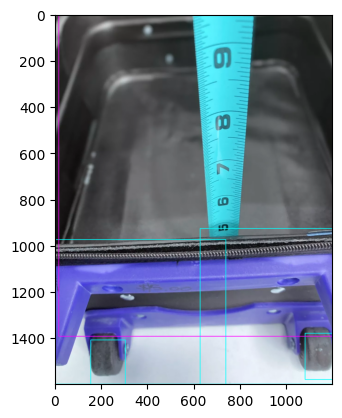

In [7]:
t_data = data1[2]
image = cv2.imread(t_data['img_path'])
def plot_box(img, box, c=(255,255,0)):
    box = np.array(box)
#     print(box.ndim)
    if box.ndim > 1:
        for b in box:
            img = cv2.rectangle(img, b[0:2], b[2:], c, 2)
    else:
        img = cv2.rectangle(img, box[0:2], box[2:], c, 2)
    return img
image = plot_box(image, t_data['all_wheel_box'])
image = plot_box(image, t_data['reliable_wheel_box']+t_data['pos_wheel_context_box'], (0,255,255))
image = plot_box(image, t_data['body_box'], (255,0,255))
plt.imshow(image)
plt.show()

In [2]:
def refine_box_coord(boxes, image):#box: xyxy
    img_h, img_w = image.shape[:2]
    boxes = np.array(boxes)
    
    boxes[:,0][boxes[:,0] < 0] = 0
    boxes[:,1][boxes[:,1] < 0] = 0
    boxes[:,2][boxes[:,2] > img_w] = img_w
    boxes[:,3][boxes[:,3] > img_h] = img_h
    return boxes

def get_body_corner_area(img, box):
    box = refine_box_coord([box], img)[0]
#     print('body_box:', box)
    p1 = np.array((box[0], box[1]))
    p2 = np.array((box[2], box[1]))
    p3 = np.array((box[2], box[3]))
    p4 = np.array((box[0], box[3]))
    points = np.array([p1,p2,p3,p4])
    body_w = box[2]-box[1]
#     print('points',points)
    
    coef = np.array([[1,1],[-1,1],[-1,-1],[1,-1]])
    inner_points = np.add(points,int(body_w/3)*coef)
    outer_points = np.add(points,int(body_w/3)*coef*(-1))
#     print('inner_points')
#     print(inner_points)
#     print('outer_points')
#     print(outer_points)
    new_box = np.concatenate((inner_points, outer_points), axis=1)
#     print(new_box)
#     print(np.min(new_box[:,::2], axis=1))
#     print(np.min(new_box[:,1::2], axis=1))
#     print(np.max(new_box[:,::2], axis=1))
#     print(np.max(new_box[:, 1::2], axis=1).reshape(1,-1).shape)
    new_box = np.array(list(zip(np.min(new_box[:,::2], axis=1), np.min(new_box[:, 1::2], axis=1), 
               np.max(new_box[:,::2], axis=1), np.max(new_box[:, 1::2], axis=1))))
    new_box = refine_box_coord(new_box, image)
    return new_box

body_box: [  45   48 1571 1200]
points [[  45   48]
 [1571   48]
 [1571 1200]
 [  45 1200]]
coner_areas
[[   0    0  552  555]
 [1064    0 1600  555]
 [1064  693 1600 1200]
 [   0  693  552 1200]]


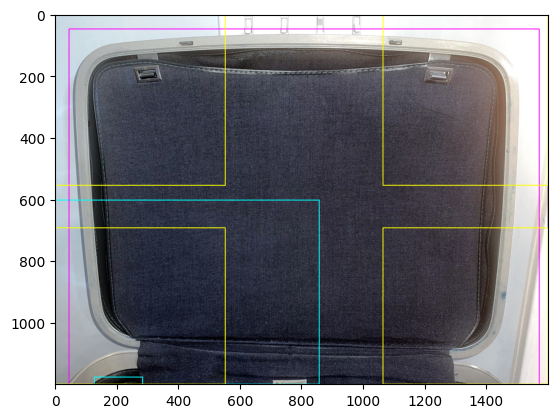

In [60]:
t_data = data1[0]
image = cv2.imread(t_data['img_path'])
def plot_box(img, box, c=(255,255,0)):
    box = np.array(box)
#     print(box.ndim)
    if box.ndim > 1:
        for b in box:
            img = cv2.rectangle(img, b[0:2], b[2:], c, 2)
    else:
        img = cv2.rectangle(img, box[0:2], box[2:], c, 2)
    return img
image = plot_box(image, t_data['all_wheel_box'])
image = plot_box(image, t_data['reliable_wheel_box']+t_data['pos_wheel_context_box'], (0,255,255))
image = plot_box(image, t_data['body_box'], (255,0,255))

coner_areas = get_body_corner_area(image, t_data['body_box'])
print('coner_areas')
print(coner_areas)
image = plot_box(image, coner_areas, (255,255,0))
plt.imshow(image)
plt.show()

In [4]:
# def gen_neg_box_from_bodyconer_area(area, expected_size):
def compute_iou_bodycorner_vs_pos_box(boxA, boxB): #corner, pos
    x1A, y1A, x2A, y2A = boxA
    x1B, y1B, x2B, y2B = boxB

    # Calculate the coordinates of the intersection rectangle
    x1_overlap = max(x1A, x1B)
    y1_overlap = max(y1A, y1B)
    x2_overlap = min(x2A, x2B)
    y2_overlap = min(y2A, y2B)

    # Calculate the width and height of the overlap
    overlap_width = max(0, x2_overlap - x1_overlap)
    overlap_height = max(0, y2_overlap - y1_overlap)

    # Calculate the area of overlap
    intersection_area = overlap_width * overlap_height

    # Calculate the area of both boxes
    areaA = (x2A - x1A) * (y2A - y1A)
    areaB = (x2B - x1B) * (y2B - y1B)

#     # Calculate the union area
#     union_area = areaA + areaB - intersection_area

    # Compute IoU
    iou = intersection_area / areaB if areaB > 0 else 0

    return iou

# neg_area = []
# for b in coner_areas:
#     neg_sign = 1
#     for pos in t_data['pos_wheel_context_box']:
#         iou_pos = compute_iou_bodycorner_vs_pos_box(b, pos)
#         print(iou_pos)
#         if iou_pos >= 0.2:
#             neg_sign = 0
#     if neg_sign == 1:
#         neg_area.append(b)
        
#     print('-'*10)
# print('neg_area:',neg_area)

In [7]:
for t_data in tqdm(data2):
    image = cv2.imread(t_data['img_path'])
    coner_areas = get_body_corner_area(image, t_data['body_box'])
    
    neg_area = []
    for b in coner_areas:
        neg_sign = 1
        for pos in t_data['pos_wheel_context_box']:
            iou_pos = compute_iou_bodycorner_vs_pos_box(b, pos)
#             print(iou_pos)
            if iou_pos >= 0.2:
                neg_sign = 0
        if neg_sign == 1:
            neg_area.append(b)
    t_data['neg_wheel_context_box'] = neg_area
    with open('luggage_parts_annotations_total_2609_newbody_pos+neg_wheel_context_box.json', 'a', encoding='utf-8') as f:
            json.dump(t_data, f, ensure_ascii=False, cls = NumpyEncoder)
            f.write('\n')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3874/3874 [01:30<00:00, 42.87it/s]


In [6]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)